Final Task 3


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.98MB/s]


===== BASELINE TRAINING =====
Epoch [10/50] | D Loss: 1.0658 | G Loss: 0.7860
Epoch [20/50] | D Loss: 1.0960 | G Loss: 1.5169
Epoch [30/50] | D Loss: 1.0346 | G Loss: 1.1999
Epoch [40/50] | D Loss: 1.1111 | G Loss: 1.2895
Epoch [50/50] | D Loss: 1.0231 | G Loss: 1.0756


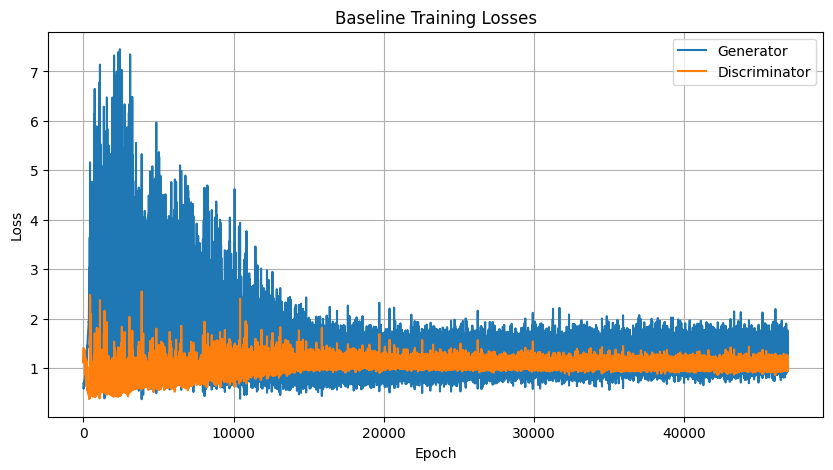

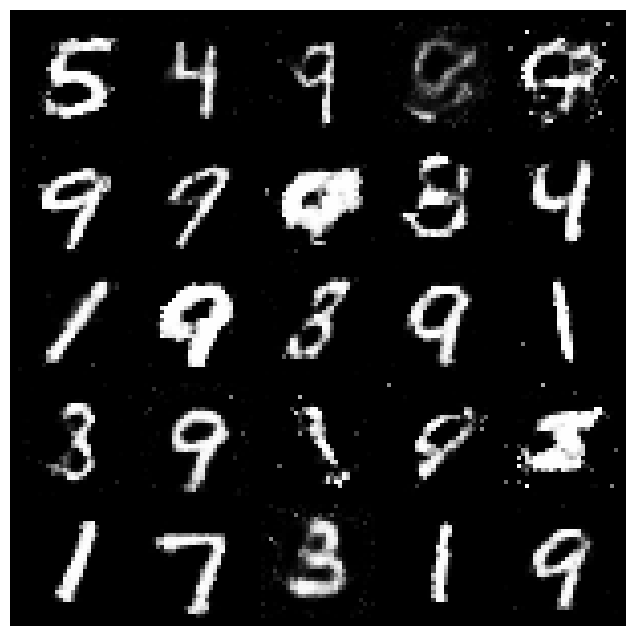


===== EXPERIMENT 1: GRADIENT VANISHING =====
Training with overpowered discriminator...
Epoch [10/30] | D Loss: 90.0000 | G Loss: 90.0000
Epoch [20/30] | D Loss: 90.0000 | G Loss: 90.0000
Epoch [30/30] | D Loss: 110.0000 | G Loss: 10.0000

Mitigating with non-saturating loss and label smoothing...
Epoch [10/30] | D Loss: 0.8358 | G Loss: 1.9884
Epoch [20/30] | D Loss: 1.2040 | G Loss: 1.5582
Epoch [30/30] | D Loss: 1.0520 | G Loss: 1.0434


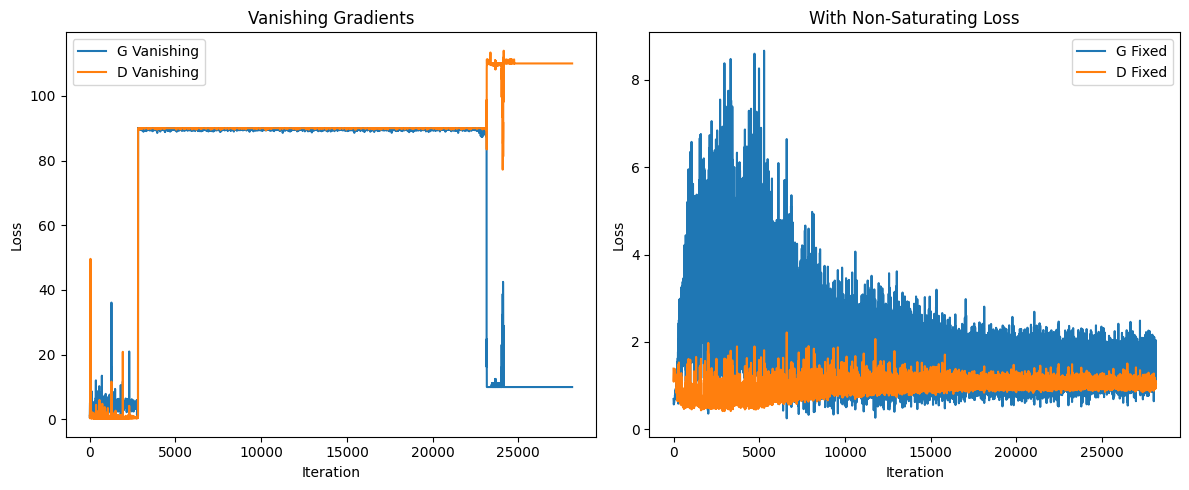

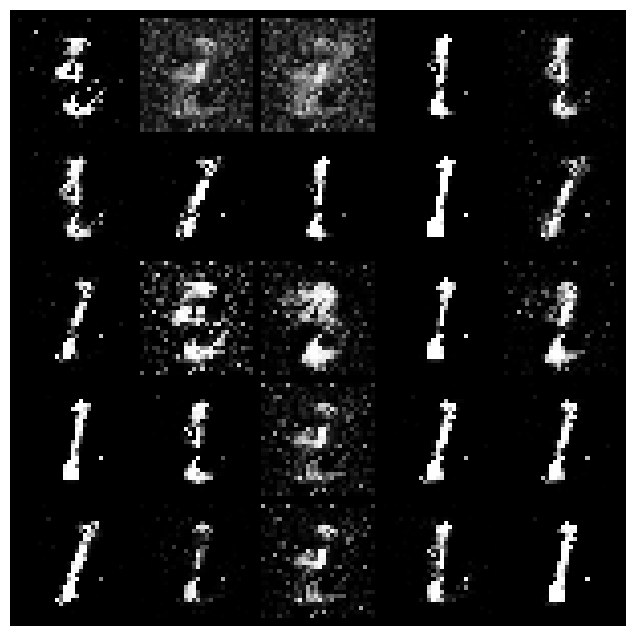

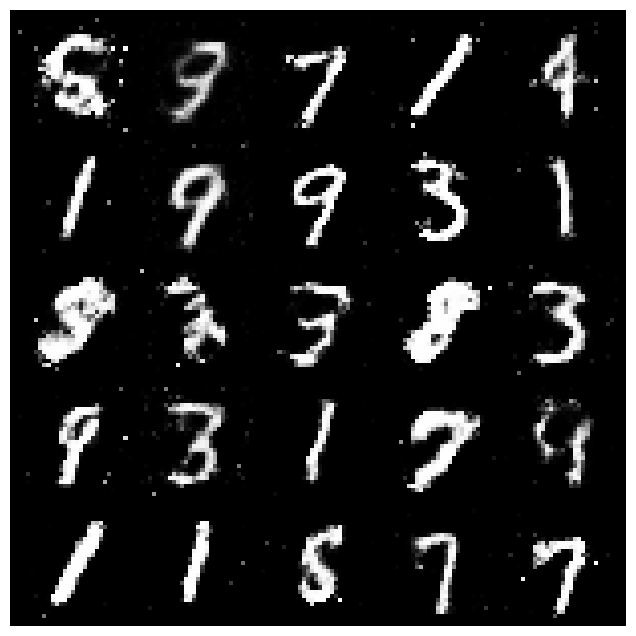


===== EXPERIMENT 2: MODE COLLAPSE =====
Inducing mode collapse with strong generator...
Epoch [10/30] | D Loss: 0.3252 | G Loss: 10.4211
Epoch [20/30] | D Loss: 0.3251 | G Loss: 12.2477
Epoch [30/30] | D Loss: 0.3251 | G Loss: 9.4973

Mitigating mode collapse with balanced training...
Epoch [10/30] | D Loss: 0.8178 | G Loss: 3.0600
Epoch [20/30] | D Loss: 0.8044 | G Loss: 1.5296
Epoch [30/30] | D Loss: 0.7606 | G Loss: 1.9212


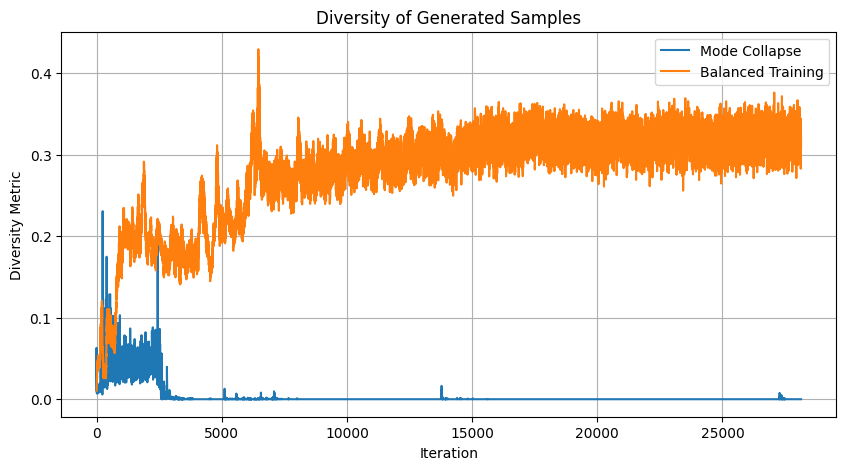

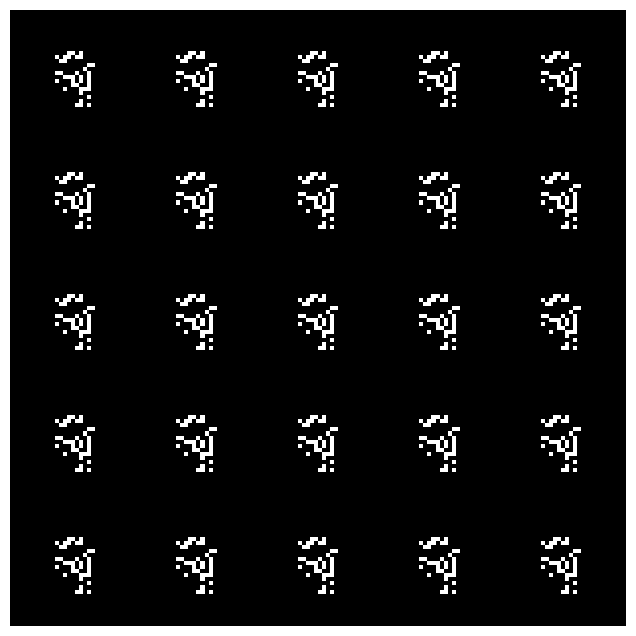

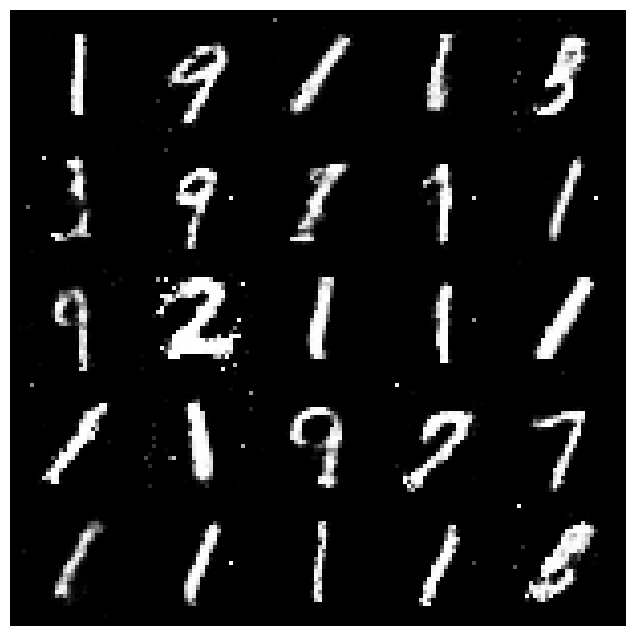


===== EXPERIMENT 3: DISCRIMINATOR OVERFITTING =====
Training on small dataset to induce overfitting...
Epoch [10/30] | D Loss: 0.8515 | G Loss: 1.0457
Epoch [20/30] | D Loss: 0.5062 | G Loss: 1.6858
Epoch [30/30] | D Loss: 0.6033 | G Loss: 2.3380

Mitigating overfitting with dropout...
Epoch [10/30] | D Loss: 0.8971 | G Loss: 1.0694
Epoch [20/30] | D Loss: 0.7401 | G Loss: 1.6805
Epoch [30/30] | D Loss: 0.5646 | G Loss: 2.1788


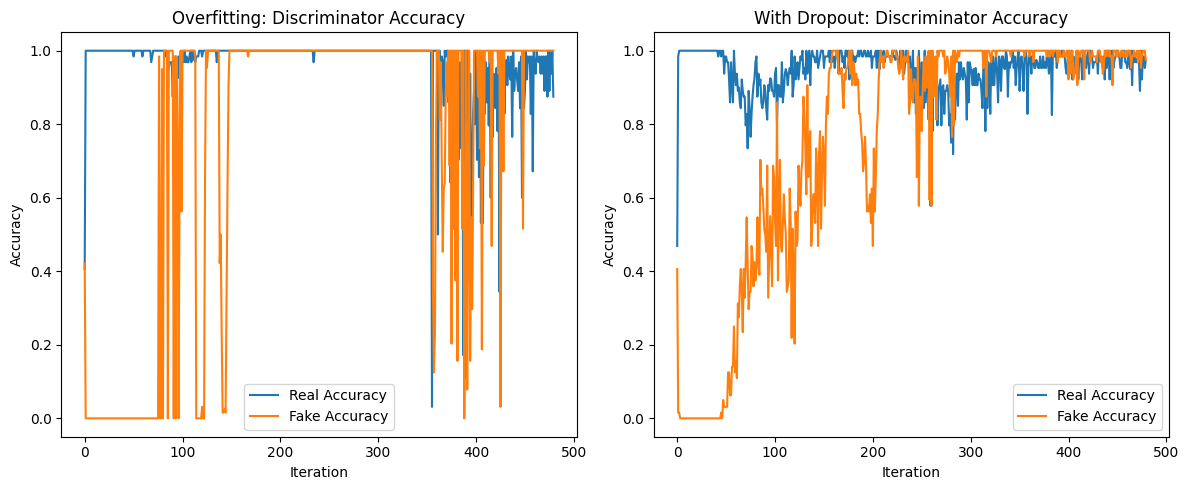

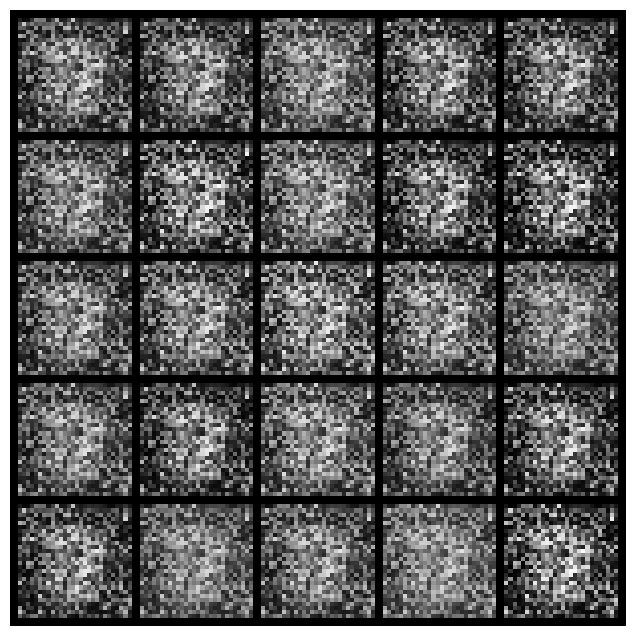

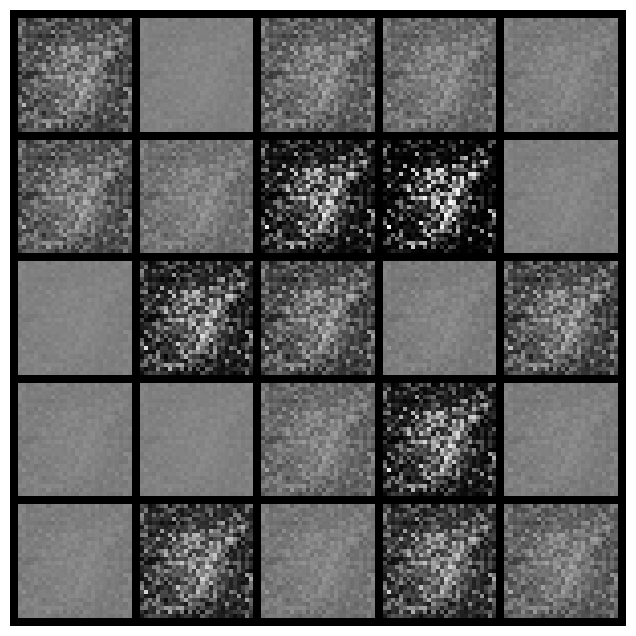


===== RESULTS ANALYSIS =====

1. BASELINE RESULTS:
Final Generator Loss: 1.0756
Final Discriminator Loss: 1.0231
Generated samples should show recognizable digit shapes with some variety

2. GRADIENT VANISHING ANALYSIS:
In the vanishing gradients experiment, we expect:
- D loss decreases rapidly while G loss remains high
- D becomes too confident (D(x) → 1, D(G(z)) → 0)
- G receives weak gradients and fails to learn
With non-saturating loss, G should receive stronger gradients and show improvement

3. MODE COLLAPSE ANALYSIS:
Mode collapse diversity: 0.0000
Balanced training diversity: 0.3203
Lower diversity indicates mode collapse (similar outputs)
Balanced training should show higher diversity (more variety in outputs)

4. DISCRIMINATOR OVERFITTING ANALYSIS:
Overfitting - Real accuracy: 0.8750, Fake accuracy: 1.0000
With dropout - Real accuracy: 0.9750, Fake accuracy: 0.9750
Extremely high accuracy indicates overfitting
Dropout should prevent D from becoming overconfident

5. COMPARI

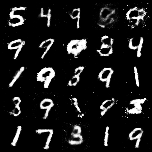

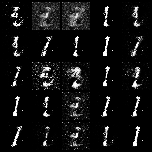

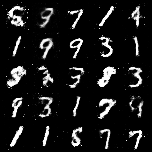

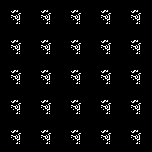

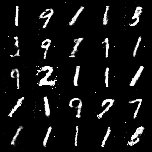

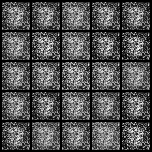

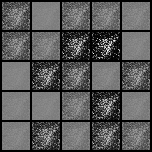

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image, display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.makedirs("samples", exist_ok=True)
os.makedirs("models", exist_ok=True)

latent_dim = 100
batch_size = 64
lr = 0.0002
epochs = 50
real_label = 0.9  
fake_label = 0.0

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

small_dataset = torch.utils.data.Subset(train_data, range(1000))
small_dataloader = torch.utils.data.DataLoader(small_dataset, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.net(z)
        return x.view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

def reset_models(g_lr=lr, d_lr=lr, d_dropout=0.0):
    """Initialize new models with specified parameters"""
    G = Generator().to(device)
    D = Discriminator(dropout_rate=d_dropout).to(device)

    G.apply(weights_init)
    D.apply(weights_init)

    optimizerG = optim.Adam(G.parameters(), lr=g_lr, betas=(0.5, 0.999))
    optimizerD = optim.Adam(D.parameters(), lr=d_lr, betas=(0.5, 0.999))

    return G, D, optimizerG, optimizerD

def plot_losses(g_losses, d_losses, title="Training Losses"):
    """Plot generator and discriminator losses"""
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(g_losses, label="Generator")
    plt.plot(d_losses, label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_samples(G, num_samples=25, filename=None):
    """Generate and display sample images from the generator"""
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        samples = G(z).cpu()

        grid = vutils.make_grid(samples, nrow=5, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis('off')

        if filename:
            vutils.save_image(samples, filename, nrow=5, normalize=True)

        plt.show()

    return samples

def calculate_diversity(samples):
    """Calculate diversity metric (standard deviation across samples)"""
    flattened = samples.view(samples.size(0), -1)
    return torch.std(flattened, dim=0).mean().item()

def train_gan(G, D, optimizerG, optimizerD, dataloader,
              use_non_saturating=False, d_steps=1, g_steps=1,
              experiment_name="baseline", max_epochs=epochs):
    """Train GAN with specified parameters"""
    criterion = nn.BCELoss()
    G_losses = []
    D_losses = []
    D_real_acc = []
    D_fake_acc = []
    diversities = []

    fixed_noise = torch.randn(25, latent_dim, device=device)

    for epoch in range(max_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            b_size = real_imgs.size(0)

            real_labels = torch.full((b_size, 1), real_label, device=device)
            fake_labels = torch.full((b_size, 1), fake_label, device=device)

            d_loss_total = 0
            for _ in range(d_steps):
                D.zero_grad()

                output_real = D(real_imgs)
                lossD_real = criterion(output_real, real_labels)

                noise = torch.randn(b_size, latent_dim, device=device)
                fake_imgs = G(noise).detach()
                output_fake = D(fake_imgs)
                lossD_fake = criterion(output_fake, fake_labels)

                lossD = lossD_real + lossD_fake
                lossD.backward()
                optimizerD.step()

                d_loss_total += lossD.item()

            g_loss_total = 0
            for _ in range(g_steps):
                G.zero_grad()

                noise = torch.randn(b_size, latent_dim, device=device)
                fake_imgs = G(noise)
                output = D(fake_imgs)

                if use_non_saturating:
                    lossG = -torch.mean(torch.log(output + 1e-8))
                else:
                    lossG = criterion(output, real_labels)

                lossG.backward()
                optimizerG.step()

                g_loss_total += lossG.item()

            D_losses.append(d_loss_total / d_steps)
            G_losses.append(g_loss_total / g_steps)

            D_real_acc.append((output_real > 0.5).float().mean().item())
            D_fake_acc.append((output_fake < 0.5).float().mean().item())

            with torch.no_grad():
                diversities.append(calculate_diversity(fake_imgs))

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{max_epochs}] | D Loss: {D_losses[-1]:.4f} | G Loss: {G_losses[-1]:.4f}")
            with torch.no_grad():
                samples = G(fixed_noise)
                vutils.save_image(samples, f'samples/{experiment_name}_epoch_{epoch+1:03d}.png',
                                 normalize=True, nrow=5)

    torch.save(G.state_dict(), f'models/{experiment_name}_G.pth')
    torch.save(D.state_dict(), f'models/{experiment_name}_D.pth')

    return G_losses, D_losses, D_real_acc, D_fake_acc, diversities
print("===== BASELINE TRAINING =====")
G_baseline, D_baseline, optimizerG_baseline, optimizerD_baseline = reset_models()
g_losses_base, d_losses_base, d_real_acc_base, d_fake_acc_base, diversities_base = train_gan(
    G_baseline, D_baseline, optimizerG_baseline, optimizerD_baseline,
    dataloader, experiment_name="baseline")

plot_losses(g_losses_base, d_losses_base, "Baseline Training Losses")
generate_samples(G_baseline, filename="samples/baseline_final.png")

print("\n===== EXPERIMENT 1: GRADIENT VANISHING =====")
print("Training with overpowered discriminator...")
G_vanishing, D_vanishing, optimizerG_vanishing, optimizerD_vanishing = reset_models(d_lr=lr*10)
g_losses_vanishing, d_losses_vanishing, _, _, _ = train_gan(
    G_vanishing, D_vanishing, optimizerG_vanishing, optimizerD_vanishing,
    dataloader, d_steps=5, experiment_name="vanishing", max_epochs=30)

print("\nMitigating with non-saturating loss and label smoothing...")
G_fixed, D_fixed, optimizerG_fixed, optimizerD_fixed = reset_models()
g_losses_fixed, d_losses_fixed, _, _, _ = train_gan(
    G_fixed, D_fixed, optimizerG_fixed, optimizerD_fixed,
    dataloader, use_non_saturating=True, experiment_name="vanishing_fixed", max_epochs=30)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(g_losses_vanishing, label="G Vanishing")
plt.plot(d_losses_vanishing, label="D Vanishing")
plt.title("Vanishing Gradients")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(g_losses_fixed, label="G Fixed")
plt.plot(d_losses_fixed, label="D Fixed")
plt.title("With Non-Saturating Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

generate_samples(G_vanishing, filename="samples/vanishing_final.png")
generate_samples(G_fixed, filename="samples/vanishing_fixed_final.png")

print("\n===== EXPERIMENT 2: MODE COLLAPSE =====")
print("Inducing mode collapse with strong generator...")
G_collapse, D_collapse, optimizerG_collapse, optimizerD_collapse = reset_models(g_lr=lr*5, d_lr=lr*0.5)
g_losses_collapse, d_losses_collapse, _, _, diversities_collapse = train_gan(
    G_collapse, D_collapse, optimizerG_collapse, optimizerD_collapse,
    dataloader, g_steps=3, experiment_name="collapse", max_epochs=30)

print("\nMitigating mode collapse with balanced training...")
G_balanced, D_balanced, optimizerG_balanced, optimizerD_balanced = reset_models()
g_losses_balanced, d_losses_balanced, _, _, diversities_balanced = train_gan(
    G_balanced, D_balanced, optimizerG_balanced, optimizerD_balanced,
    dataloader, d_steps=2, experiment_name="collapse_fixed", max_epochs=30)

plt.figure(figsize=(10, 5))
plt.plot(diversities_collapse, label="Mode Collapse")
plt.plot(diversities_balanced, label="Balanced Training")
plt.title("Diversity of Generated Samples")
plt.xlabel("Iteration")
plt.ylabel("Diversity Metric")
plt.legend()
plt.grid(True)
plt.show()

generate_samples(G_collapse, filename="samples/collapse_final.png")
generate_samples(G_balanced, filename="samples/collapse_fixed_final.png")

print("\n===== EXPERIMENT 3: DISCRIMINATOR OVERFITTING =====")
print("Training on small dataset to induce overfitting...")
G_overfit, D_overfit, optimizerG_overfit, optimizerD_overfit = reset_models()
g_losses_overfit, d_losses_overfit, d_real_acc_overfit, d_fake_acc_overfit, _ = train_gan(
    G_overfit, D_overfit, optimizerG_overfit, optimizerD_overfit,
    small_dataloader, experiment_name="overfitting", max_epochs=30)

print("\nMitigating overfitting with dropout...")
G_dropout, D_dropout, optimizerG_dropout, optimizerD_dropout = reset_models(d_dropout=0.4)
g_losses_dropout, d_losses_dropout, d_real_acc_dropout, d_fake_acc_dropout, _ = train_gan(
    G_dropout, D_dropout, optimizerG_dropout, optimizerD_dropout,
    small_dataloader, experiment_name="overfitting_fixed", max_epochs=30)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(d_real_acc_overfit, label="Real Accuracy")
plt.plot(d_fake_acc_overfit, label="Fake Accuracy")
plt.title("Overfitting: Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(d_real_acc_dropout, label="Real Accuracy")
plt.plot(d_fake_acc_dropout, label="Fake Accuracy")
plt.title("With Dropout: Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

generate_samples(G_overfit, filename="samples/overfitting_final.png")
generate_samples(G_dropout, filename="samples/overfitting_fixed_final.png")

